In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
torch.manual_seed(42)

### 1 Алгоритм Гиббса для динамического ценообразования

#### 1.1 Генерация синтеческих данных

In [ ]:
n_samples = 500

true_params = torch.tensor([2.0, 5.0, -3.0])
X = torch.stack([
    torch.randint(50, 200, (n_samples,), dtype=torch.float32), # спрос
    torch.randint(0, 2, (n_samples,), dtype=torch.float32),    # сезонность
    torch.randint(0, 3, (n_samples,), dtype=torch.float32),    # погодные условия
], dim=1)

noise = torch.randn(n_samples) * 5.0
y = X @ true_params + noise

#### 1.2 Реализация алгоритма Гиббса

In [ ]:
def gibbs_sampler(n_iter, X, y, sigma2=25.0, tau2=100.0):
    n, d = X.shape
    samples = torch.zeros((n_iter, d))
    w = torch.zeros(d)

    XT_X = X.T @ X
    XT_y = X.T @ y

    for t in range(n_iter):
        for j in range(d):
            X_j = X[:, j]
            X_notj = X[:, [i for i in range(d) if i != j]]
            w_notj = w[[i for i in range(d) if i != j]]
            y_resid = y - X_notj @ w_notj

            mu_j = (X_j @ y_resid) / (X_j @ X_j + sigma2 / tau2)
            var_j = sigma2 / (X_j @ X_j + sigma2 / tau2)

            w[j] = torch.normal(mu_j, torch.sqrt(var_j))

        samples[t] = w.clone()

    return samples

#### 1.3 Визуализация траекторий параметров

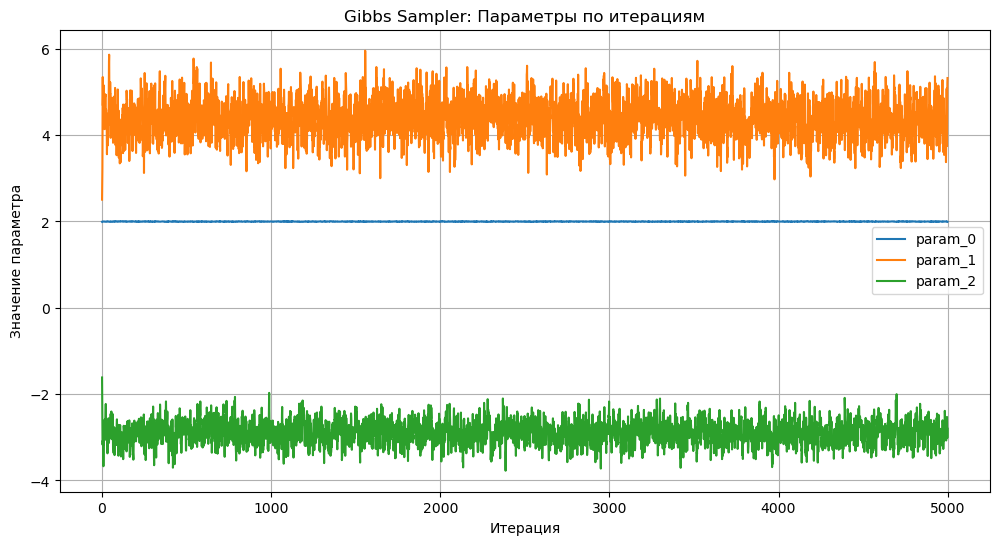

In [ ]:
samples_gibbs = gibbs_sampler(5000, X, y)

plt.figure(figsize=(12, 6))
for i in range(samples_gibbs.shape[1]):
    plt.plot(samples_gibbs[:, i], label=f'param_{i}')
plt.title("Gibbs Sampler: Параметры по итерациям")
plt.xlabel("Итерация")
plt.ylabel("Значение параметра")
plt.legend()
plt.grid(True)
plt.show()

#### 1.4 Гистограммы апостериорных распределений

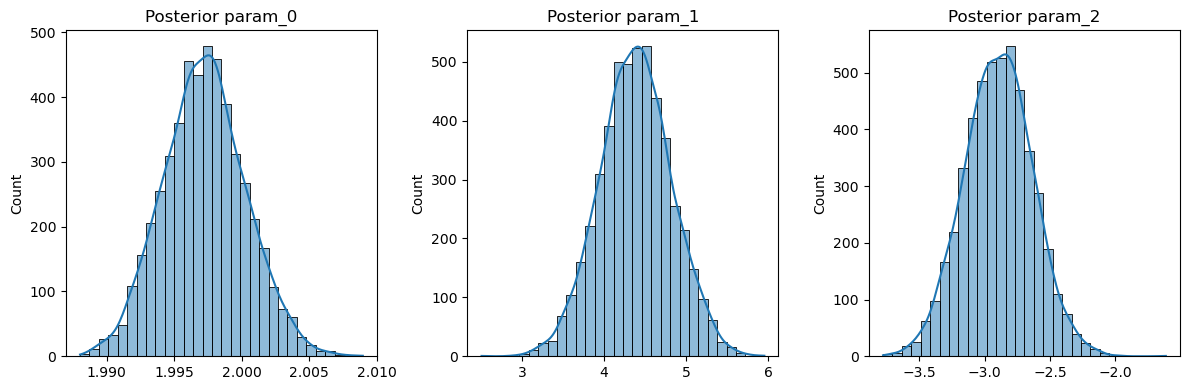

In [ ]:
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    sns.histplot(samples_gibbs[:, i].numpy(), kde=True, bins=30)
    plt.title(f'Posterior param_{i}')
plt.tight_layout()
plt.show()

### 2 Яндекс.Такси

#### 2.1 Генерация синтетических данных

In [7]:
n = 1000

true_weights = torch.tensor([3.5, -2.0, 1.5, 0.5, 0.8, 1.2, -1.0, 2.5])
X = torch.stack([
    torch.randint(10, 300, (n,), dtype=torch.float32),  # спрос
    torch.randint(0, 3, (n,), dtype=torch.float32),     # погода
    torch.randint(0, 24, (n,), dtype=torch.float32),    # час суток
    torch.randint(1, 8, (n,), dtype=torch.float32),     # день недели
    torch.randint(1, 50, (n,), dtype=torch.float32),    # расстояние
    torch.randint(0, 11, (n,), dtype=torch.float32),    # трафик
    torch.randint(1, 30, (n,), dtype=torch.float32),    # конкуренция
    torch.randint(0, 2, (n,), dtype=torch.float32),     # сезон
], dim=1)

noise = torch.randn(n) * 10
y = X @ true_weights + noise

#### 2.2 Реализация алгоритма Метрополиса-Хастингса

In [16]:
def log_prob_mh(w, X, y, sigma2=100.0):
    prior = -0.5 * torch.sum(w**2)
    likelihood = -0.5 / sigma2 * torch.sum((y - X @ w) ** 2)
    return prior + likelihood

def metropolis_hastings(n_iter, X, y, proposal_std=0.1):
    d = X.shape[1]
    samples = []
    w = torch.randn(d)

    for _ in range(n_iter):
        w_prop = w + torch.randn(d) * proposal_std
        log_ratio = log_prob_mh(w_prop, X, y) - log_prob_mh(w, X, y)

        if torch.log(torch.rand(1)) < log_ratio:
            w = w_prop

        samples.append(w.clone())

    return torch.stack(samples)

In [9]:
samples_gibbs_yandex = gibbs_sampler(5000, X, y)
samples_mh_yandex = metropolis_hastings(5000, X, y)

#### 2.3 Визуализация траекторий параметров

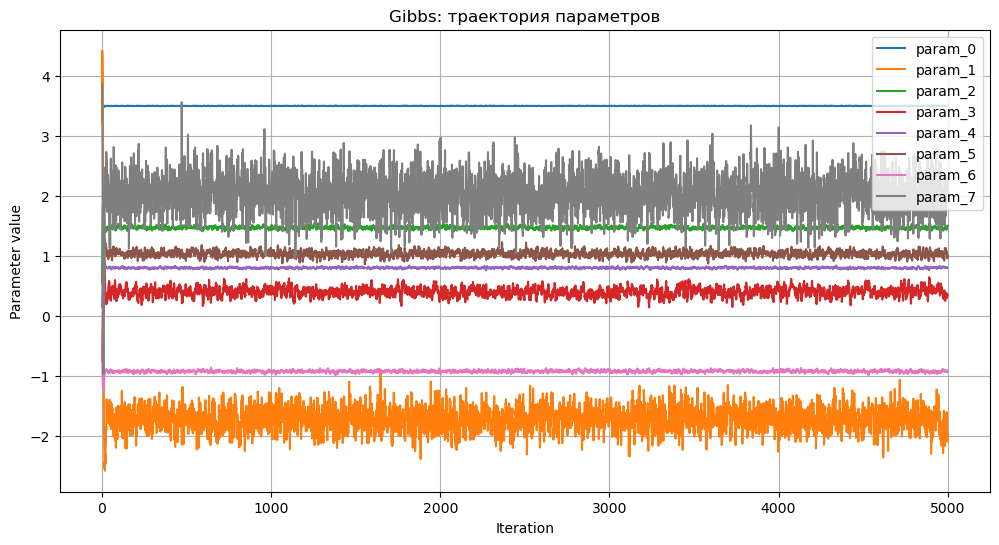

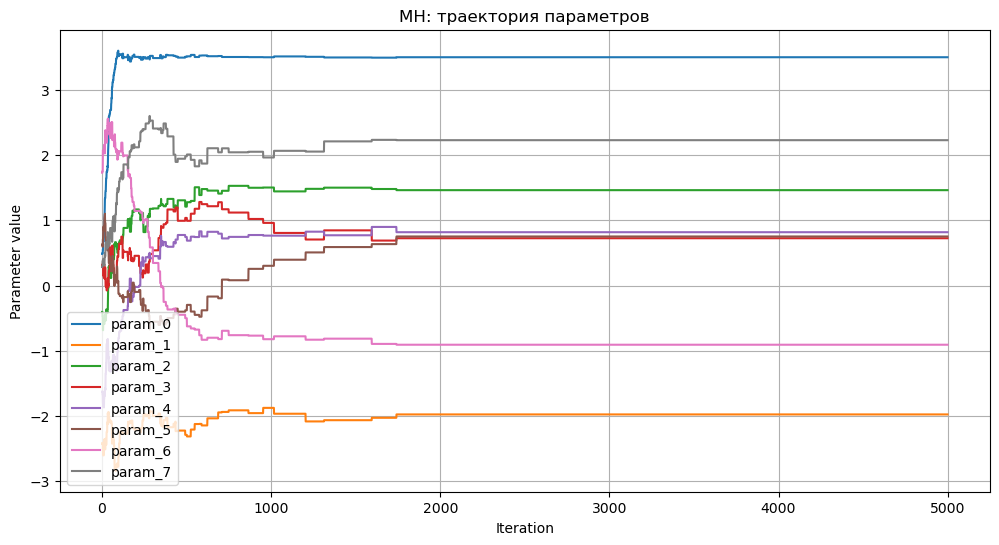

In [11]:
def plot_trajectories(samples, title):
    plt.figure(figsize=(12, 6))
    for i in range(samples.shape[1]):
        plt.plot(samples[:, i], label=f'param_{i}')
    plt.title(title)
    plt.xlabel("Iteration")
    plt.ylabel("Parameter value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_trajectories(samples_gibbs_yandex, "Gibbs: траектория параметров")
plot_trajectories(samples_mh_yandex, "MH: траектория параметров")

#### 2.4 Гистограммы апостериорных распределений

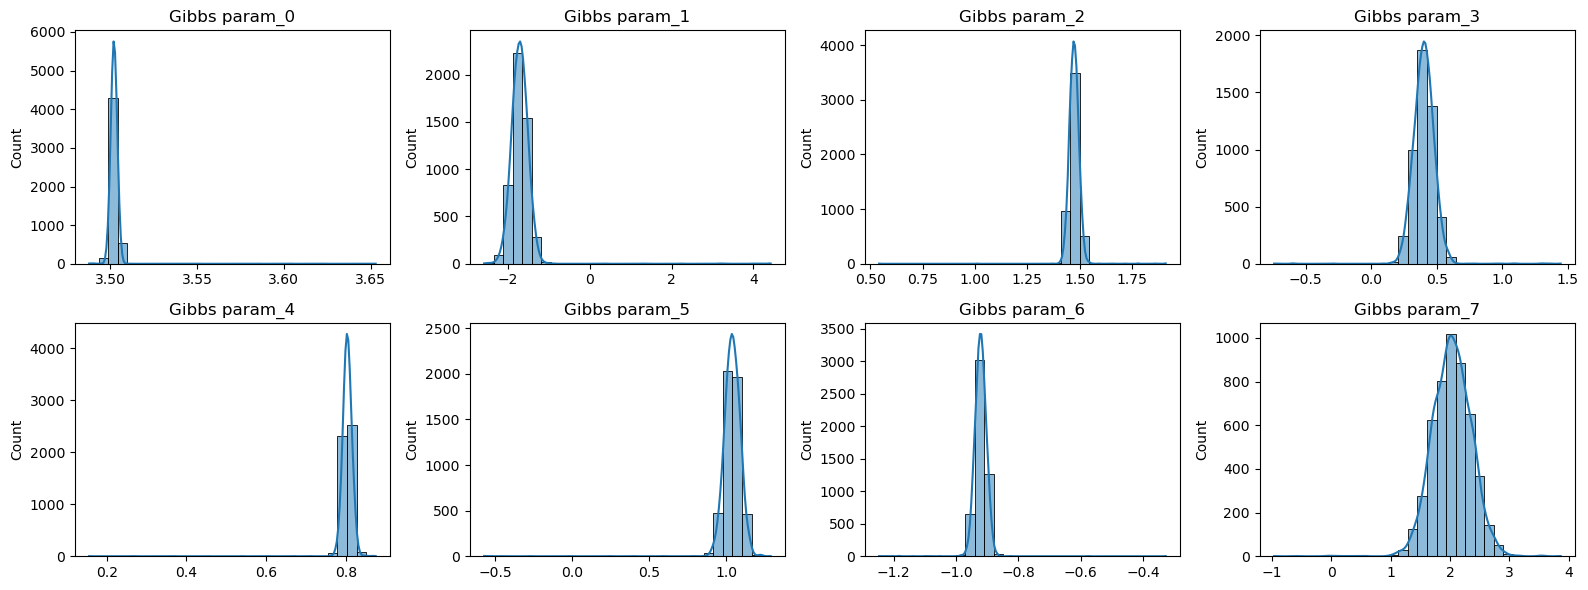

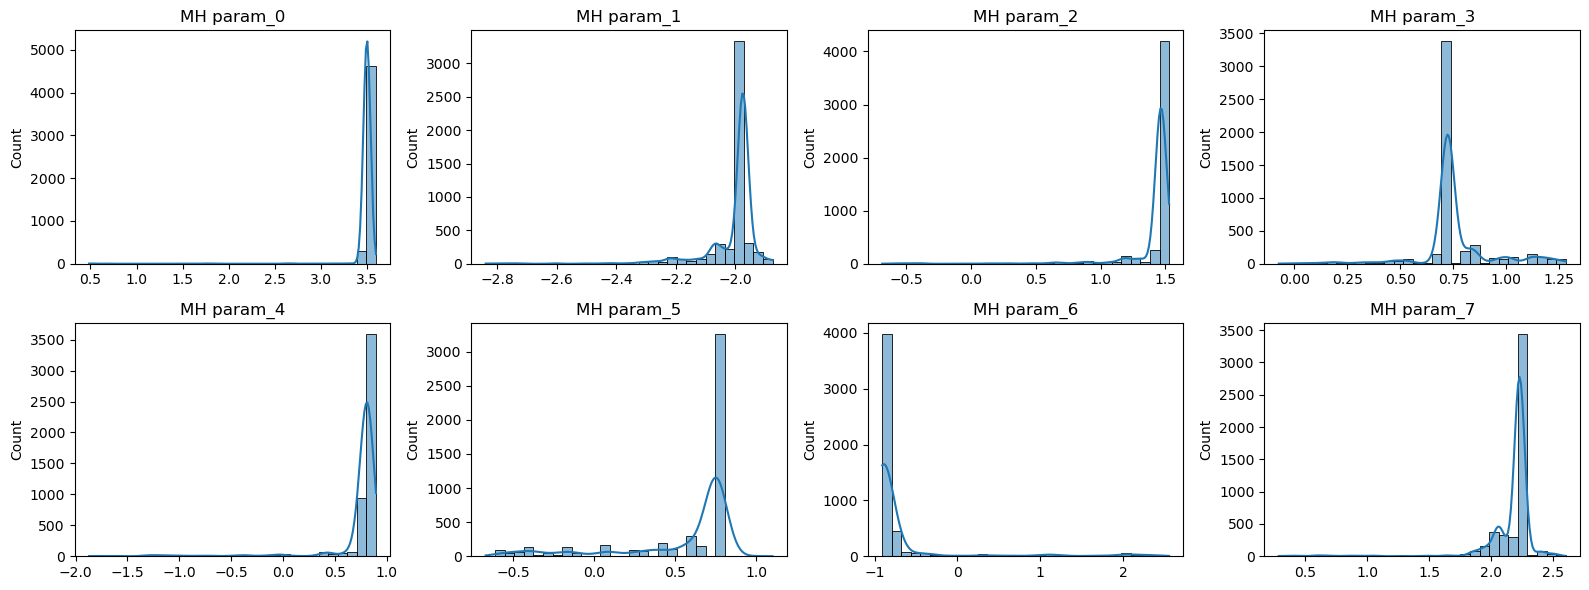

In [15]:
def plot_posteriors(samples, algo_name):
    plt.figure(figsize=(16, 6))
    for i in range(samples.shape[1]):
        plt.subplot(2, 4, i+1)
        sns.histplot(samples[:, i].numpy(), kde=True, bins=30)
        plt.title(f'{algo_name} param_{i}')
    plt.tight_layout()
    plt.show()

plot_posteriors(samples_gibbs_yandex, "Gibbs")
plot_posteriors(samples_mh_yandex, "MH")

#### 2.5 Прогнозирование на новых данных

In [14]:
X_new = X[:10]
mean_gibbs = samples_gibbs_yandex.mean(dim=0)
mean_mh = samples_mh_yandex.mean(dim=0)

preds_gibbs = X_new @ mean_gibbs
preds_mh = X_new @ mean_mh

print("Gibbs prediction:", preds_gibbs)
print("MH prediction:", preds_mh)

Gibbs prediction: tensor([275.5598, 160.0930, 430.1014, 498.1383, 419.5461, 865.5938, 190.4788,
        404.7104, 441.9506, 970.7958])
MH prediction: tensor([275.5059, 161.6437, 423.0361, 491.8763, 415.3034, 855.9485, 187.1581,
        401.8465, 436.5966, 966.4635])


### 3 Выводы


Гиббс-семплирование:

1. Все параметры демонстрируют хорошую стационарность и быструю сходимость.

2. Нет выраженных автокорреляций, значения колеблются около стабильных средних.

3. Траектории плотные и гладкие, особенно на первых трёх параметрах, что говорит о низкой дисперсии.

Метрополис-Хастингс (MH):

1. Алгоритм долго разогревается: траектории "ползут" к нужному значению, особенно в первые 1000 итераций.

2. MH-переходы дискретны — много отторгнутых предложений, особенно видно ступенчатость.

3. Есть сильная автокорреляция, параметры залипают на одинаковых значениях, что видно по скачкообразным траекториям.

### 4 Ответы на вопросы

1. Как отличаются результаты алгоритма Гиббса и Метрополиса-Хастингса на второй задаче?


| Критерий      | Гиббс                | Метрополис-Хастингс          |
| ------------- | -------------------- | ---------------------------- |
| Сходимость    | Быстрая              | Медленная, требует разогрева |
| Стабильность  | Высокая              | Низкая (частые залипания)    |
| Распределения | Нормальные и гладкие | Шумные, часто с выбросами    |
| Прогнозы      | Точные и устойчивые  | Чуть менее устойчивые        |

2. Какие из алгоритмов эффективнее с точки зрения времени сходимости?

Гиббс-семплирование эффективнее в данной задаче, так как быстрее достигает стационарного распределения.

3. Как можно улучшить производительность алгоритмов МЦМК?

    * Использование ковариационной матрицы в алгоритме Гиббса снижает зависимость между параметрами. Это помогает алгоритму быстрее и стабильнее сходиться, особенно при высокой размерности;
    
    * Добавление регуляризации с помощью априорных распределений помогает избежать переобучения, особенно когда данный мало или они шумные. Априоры сглаживают оценки, не давая модели слишком сильно подстраиваться под случайные колебания в данных.